<a href="https://colab.research.google.com/github/vladislavdarii/Ship-classification-using-Machine-Learning-techniques/blob/main/1_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1.0 Imports and drive mount

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import librosa
import pandas as pd
import scipy.signal

#Writing and loading variables
import pickle

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.manifold import TSNE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title 1.1 Function: Class Accuracy Plot and Metrics

def plot_class_acc(y_val, y_pred, strr):

  # Initialize the lists for correctly and incorrectly predicted values
  correct_preds = [0, 0, 0, 0]
  incorrect_preds = [0, 0, 0, 0]

  # Loop over the samples in y_test and y_pred
  for i in range(len(y_val)):
      if y_val[i] == y_pred[i]:
          correct_preds[y_val[i]] += 1
      else:
          incorrect_preds[y_val[i]] += 1

  # Set the colors for the bars
  bar_colors = ['#009965', '#a52a2b']

  # Create the bar chart with two parts for each bar
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.bar(range(len(correct_preds)), correct_preds, color=bar_colors[0], label='Correct Predictions')
  ax.bar(range(len(incorrect_preds)), incorrect_preds, bottom=correct_preds, color=bar_colors[1], label='Incorrect Predictions')

  for i, (corr, incorr) in enumerate(zip(correct_preds, incorrect_preds)):
      ax.text(i, corr/2, str(corr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
      ax.text(i, corr + incorr/2, str(incorr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

  # Set the x-ticks and labels
  ax.set_xticks(range(len(correct_preds)))
  ax.set_xticklabels(['Class A', 'Class B', 'Class C', 'Class D'])

  # Set the labels and title
  ax.set_xlabel('Boat Type')
  ax.set_ylabel('Count')
  ax.set_title(strr)

  # Add the legend
  ax.legend()

  # Show the plot
  plt.show()

  # #Metric calculation
  # Create confusion matrix
  cm = confusion_matrix(y_val, y_pred)

  # Convert the confusion matrix to a pandas DataFrame
  confusion_matrix_df = pd.DataFrame(cm, columns=['Class A', 'Class B', 'Class C', 'Class D'])

  # Calculate metrics
  metrics_df = calculate_metrics(confusion_matrix_df.values)

  # Print the results
  print("Confusion Matrix:")
  print(confusion_matrix_df)
  print("\nMetrics:")
  print(metrics_df)

  return metrics_df, confusion_matrix_df

def calculate_metrics(confusion_matrix):
    tp = np.diagonal(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - tp
    fn = confusion_matrix.sum(axis=1) - tp
    tn = confusion_matrix.sum() - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

    metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    }
    #Get rid of NaN values
    metrics_dict = pd.DataFrame(metrics_dict)
    metrics_dict.fillna(0, inplace=True)
    return metrics_dict

#@title 5.1 Get final metrics

def metrics_avg_var(metrics):
 row = [0,1,2,3]
 Precision = []
 Recall = []
 F1_Score = []
 Accuracy = []
 Precision_var = []
 Recall_var = []
 F1_Score_var = []
 Accuracy_var = []

 for a in row:
  Precision.append(np.average([df.loc[a, 'Precision'] for df in metrics]))
  Recall.append(np.average([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score.append(np.average([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy.append(np.average([df.loc[a, 'Accuracy'] for df in metrics]))
  Precision_var.append(np.std([df.loc[a, 'Precision'] for df in metrics]))
  Recall_var.append(np.std([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score_var.append(np.std([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy_var.append(np.std([df.loc[a, 'Accuracy'] for df in metrics]))

 metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': Precision,
        'P_std' : Precision_var,
        'Recall': Recall,
        'R_std' : Recall_var,
        'F1 Score': F1_Score,
        'F1_std': F1_Score_var,
        'Accuracy': Accuracy,
        'Acc_std': Accuracy_var
    }


 return pd.DataFrame(metrics_dict)

In [ ]:
#@title 2.1 Data Load

def dataload(datax):
  # Define the directory where the file is saved
  directory = "./drive/MyDrive/TFG/Data/"

  # Load the variables from the file
  with open(os.path.join(directory, datax), "rb") as f:
      X_train, X_test, X_val, y_train, y_test, y_val = pickle.load(f)

  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  return X_train, X_test, X_val, y_train, y_test, y_val

def save_model(model,modeltype,n):

  model_filename = "LR_" + str(modeltype) +  "_" + str(n) + ".pkl"

  # Define the directory where you want to save the file
  directory = "./drive/MyDrive/TFG/Models/" # Change to /LR/ to actually overwrite existing models

  # Save the variables to a file
  with open(os.path.join(directory, model_filename), "wb") as f:
      pickle.dump((model), f)
  return

In [ ]:
#@title 3.1 Feature extraction: PSD

def get_psd():

  psd_train = []
  psd_test = []
  psd_val = []

  # Calculate the zero-crossing rate for X_train
  for audio in X_train:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024) # best so far 2*1024
    psd_train.append(S/max(S))

  psd_train = np.array(psd_train)

  # Calculate the zero-crossing rate for X_val
  for audio in X_val:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_val.append(S/max(S))

  psd_val = np.array(psd_val)

  # Calculate the zero-crossing rate for X_test
  for audio in X_test:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_test.append(S/max(S))

  psd_test = np.array(psd_test)
  return psd_train, psd_val, psd_test

In [ ]:
#@title 3.3 Feature extraction: MFCC
def get_mfcc():
# Define the frame length and hop length in samples
  frame_length = 2000
  hop_length =  1000

  # Define the number of MFCCs to extract
  num_mfcc = 15

  # Define the sampling rate of the audio signals
  sr = 52734

  mfcc_train = []
  mfcc_val = []
  mfcc_test = []

  # Extract MFCC features for the training set
  for audio in X_train:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_train.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_train = np.array(mfcc_train)


  # Extract MFCC features for the validation set
  for audio in X_val:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_val.append(mfcc.flatten())


  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_val = np.array(mfcc_val)

  # Extract MFCC features for the test set
  for audio in X_test:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length )#,fmin = 25, fmax = 7500)
      mfcc_test.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_test = np.array(mfcc_test)
  return  mfcc_train, mfcc_val, mfcc_test

In [ ]:
#@title 4.1 LR Raw data
def get_LR_rawdata(n):
  # LR model creation
  LR = LogisticRegression(solver = 'newton-cg',C = 0.8)

  # Fit LR model
  LR.fit(X_train, y_train)

  # Evaluate the accuracy of the model on validation data
  y_pred = LR.predict(X_val)
  x = plot_class_acc(y_val, y_pred, "Validation Data")

  # Overfitting test
  y_pred = LR.predict(X_train)
  x = plot_class_acc(y_train, y_pred, "Train Data")

  y_pred = LR.predict(X_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")

  save_model(LR,"raw",n)
  return metrics, matrix

In [ ]:
#@title 4.2 LR MFCC
def get_LR_mfcc(n):
  # LR model creation
  LR_mfcc = LogisticRegression(solver = 'newton-cg', C =0.8)

  # Fit LR model
  LR_mfcc.fit(mfcc_train, y_train)

  # Evaluate the accuracy of the model on validation data
  y_pred = LR_mfcc.predict(mfcc_val)
  x = plot_class_acc(y_val, y_pred, "Validation Data")

  # Overfitting test
  y_pred = LR_mfcc.predict(mfcc_train)
  x = plot_class_acc(y_train, y_pred, "Train Data")

    # Overfitting test
  y_pred = LR_mfcc.predict(mfcc_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")

  save_model(LR_mfcc,"mfcc",n)
  return metrics, matrix

In [ ]:
from scipy.special import xlogy
#@title 4.3 LR PSD

def get_LR_psd(n):
  LR_psd = LogisticRegression(solver = 'newton-cg', C =0.8)

  LR_psd.fit(psd_train, y_train)

  # Evaluate the accuracy of the model
  y_pred = LR_psd.predict(psd_val)
  x = plot_class_acc(y_val, y_pred, "Validation Data")

  # Overfitting test
  y_pred = LR_psd.predict(psd_train)
  x = plot_class_acc(y_train, y_pred, "Train Data")

 # test data
  y_pred = LR_psd.predict(psd_test)
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")

  save_model(LR_psd,"psd",n)
  return metrics, matrix

In [ ]:
#@title 5.2 Test results extraction

# Metric activator
raw = 1
mfcc = 1
psd = 1


metrics_raw1 = []
metrics_mfcc1 = []
metrics_psd1 = []
matrix_raw = []
matrix_mfcc = []
matrix_psd = []
val = 1
data = ['data1.pkl','data2.pkl','data3.pkl','data4.pkl','data5.pkl']

for d in data:
  X_train, X_test, X_val, y_train, y_test, y_val = dataload(d)

  if raw == 1:
  # Get raw data
    metrics, matrix = get_LR_rawdata(val)
    metrics_raw1.append(metrics)
    matrix_raw.append(matrix)
  if mfcc == 1:
  # Get mfcc data
    mfcc_train, mfcc_val, mfcc_test = get_mfcc()
    metrics1, matrix1 = get_LR_mfcc(val)
    metrics_mfcc1.append(metrics1)
    matrix_mfcc.append(matrix1)
 # Get psd data
  if psd == 1:
    psd_train, psd_val, psd_test = get_psd()
    metrics2, matrix2 = get_LR_psd(val)
    metrics_psd1.append(metrics2)
    matrix_psd.append(matrix2)
  val = val + 1

pd.options.display.float_format = '{:.3f}'.format

if raw == 1:
  metrics_raw = metrics_avg_var(metrics_raw1)
if mfcc == 1:
  metrics_mfcc = metrics_avg_var(metrics_mfcc1)
if psd == 1:
  metrics_psd = metrics_avg_var(metrics_psd1)


KeyboardInterrupt: ignored

In [ ]:
#@title Print Table

def get_number(row,col, metrics):
 cols = ['Precision','Recall','F1 Score']
 a = metrics.at[row,col]
 highest = 0
 if col in cols:
  for value in metrics[col]:
    if value > a:
      highest = 1
  if highest == 0:
    a = "\highest{" + str(a) + "}"
 return str(a)

def print_table(metrics):

#metrics table formatting


  columns_to_format = ['Precision',
                        'Recall',
                        'F1 Score',
                          'Accuracy']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)
  columns_to_format = ['P_std','R_std','F1_std','Acc_std']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)

  print("\\begin{table}[H]"
  "\centering"
    "\\begin{tabular}{@{} >{\centering\\arraybackslash}p{2.5cm}"
                  "rr"
                  "rr"
                  "rr"
                  "@{}}"
  )
  print("\\toprule"
  "\\multicolumn{7}{c}{\\textbf{Logistic Regression}}"                                                                                                                                                     "\\\\ \midrule"
                                                  "    & \multicolumn{2}{c}{\\textbf{Precision($\sigma$)}} & \multicolumn{2}{c}{\\textbf{Recall($\sigma$)}} & \multicolumn{2}{c}{\\textbf{F1-Score($\sigma$)}} \\\\ \cmidrule(lr){2-3} \cmidrule(l){4-5} \cmidrule(l){6-7} "
  "Class A                           & " + get_number(0,'Precision',metrics) + "                               & (" + get_number(0,'P_std',metrics) + ")     & " + get_number(0,'Recall',metrics) + "                         & (" + get_number(0,'R_std',metrics) + ")         & " + get_number(0,'F1 Score',metrics) + "                  & (" + get_number(0,'F1_std',metrics) + ")                   \\\\"
  " \\rowcolor[HTML]{EFEFEF} Class B                           & " + get_number(1,'Precision',metrics) + "                               & (" + get_number(1,'P_std',metrics) + ")      & " + get_number(1,'Recall',metrics) + "                         & (" + get_number(1,'R_std',metrics) + ")         & " + get_number(1,'F1 Score',metrics) + "                  & (" + get_number(1,'F1_std',metrics) + ")                  \\\\"
  "Class C                           & " + get_number(2,'Precision',metrics) + "                               & (" + get_number(2,'P_std',metrics) + ")      & " + get_number(2,'Recall',metrics) + "                        & (" + get_number(2,'R_std',metrics) + ")         & " + get_number(2,'F1 Score',metrics) + "                  & (" + get_number(2,'F1_std',metrics) + ")                  \\\\")
  print("\\rowcolor[HTML]{EFEFEF} "
  "Class D                           & " + get_number(3,'Precision',metrics) + "                              & (" + get_number(3,'P_std',metrics) + ")      & " + get_number(3,'Recall',metrics) + "                         & (" + get_number(3,'R_std',metrics) + ")         & " + get_number(3,'F1 Score',metrics) + "                  & (" + get_number(3,'F1_std',metrics) + ")                 \\\\ \midrule"
  "\\multicolumn{1}{c}{\\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \\textbf{" + get_number(3,'Accuracy',metrics) + "}         & \\textbf{(" + get_number(2,'Acc_std',metrics) + ")}        \\\\  \\bottomrule"
  "\\end{tabular}"
      "\caption{Caption}"
      "\label{tab:my_label}"
  "\\end{table}")
  return


print_table(metrics_psd)

\begin{table}[H]\centering\begin{tabular}{@{} >{\centering\arraybackslash}p{2.5cm}rrrrrr@{}}
\toprule\multicolumn{7}{c}{\textbf{Logistic Regression}}\\ \midrule    & \multicolumn{2}{c}{\textbf{Precision($\sigma$)}} & \multicolumn{2}{c}{\textbf{Recall($\sigma$)}} & \multicolumn{2}{c}{\textbf{F1-Score($\sigma$)}} \\ \cmidrule(lr){2-3} \cmidrule(l){4-5} \cmidrule(l){6-7} Class A                           & 0.763                               & (0.011)     & 0.755                         & (0.031)         & 0.759                  & (0.017)                   \\ \rowcolor[HTML]{EFEFEF} Class B                           & 0.784                               & (0.029)      & 0.689                         & (0.022)         & 0.733                  & (0.021)                  \\Class C                           & 0.769                               & (0.015)      & 0.794                        & (0.008)         & 0.781                  & (0.009)                  \\
\rowcolor[HTML]{EFEFEF} Class D

In [ ]:
#@title Print Matrix

def get_max_matrix(matrix):
  a = 0
  pos = 5
  tp_max = 0
  for m in matrix:
    tp = sum(np.diagonal(m))
    if tp_max < tp:
      tp_max = tp
      pos = a
    a = a+1
  return pos

def get_matrix(matrix):
  matrix = matrix[get_max_matrix(matrix)]
  col = ['Class A','Class B','Class C','Class D']
  for i in list(range(4)):
    for j in list(range(4)):
      print(j,i,matrix.at[i,col[j]])

print("x y C")
get_matrix(matrix_raw)


x y C
0 0 121
1 0 69
2 0 97
3 0 96
0 1 91
1 1 81
2 1 74
3 1 65
0 2 153
1 2 95
2 2 173
3 2 133
0 3 137
1 3 103
2 3 119
3 3 111


In [ ]:
metrics_raw

,Class,Precision,P_std,Recall,R_std,F1 Score,F1_std,Accuracy,Acc_std
0,Class 0,0.227,0.007,0.295,0.016,0.257,0.010,0.270,0.008
1,Class 1,0.215,0.019,0.235,0.023,0.224,0.021,0.270,0.008
2,Class 2,0.345,0.020,0.294,0.015,0.317,0.016,0.270,0.008
3,Class 3,0.281,0.028,0.244,0.014,0.261,0.019,0.270,0.008


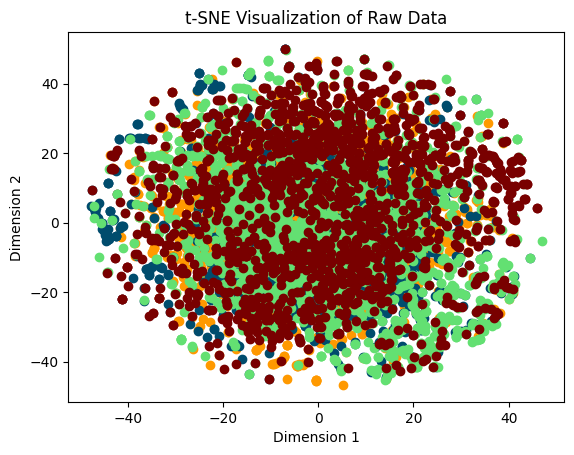

In [ ]:
#@title Raw data t-SNE Visualization

tsne = TSNE(n_components=2,perplexity = 15, random_state=42)
data_2d = tsne.fit_transform(np.array(X_train))
plt.scatter(data_2d[y_train==0, 0], data_2d[y_train==0, 1], label='Class A', color='#FF9900')
plt.scatter(data_2d[y_train==1, 0], data_2d[y_train==1, 1], label='Class B', color='#004C6D')
plt.scatter(data_2d[y_train==2, 0], data_2d[y_train==2, 1], label='Class C', color='#63E072')
plt.scatter(data_2d[y_train==3, 0], data_2d[y_train==3, 1], label='Class D', color='#790000')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization of Raw Data')

plt.show()

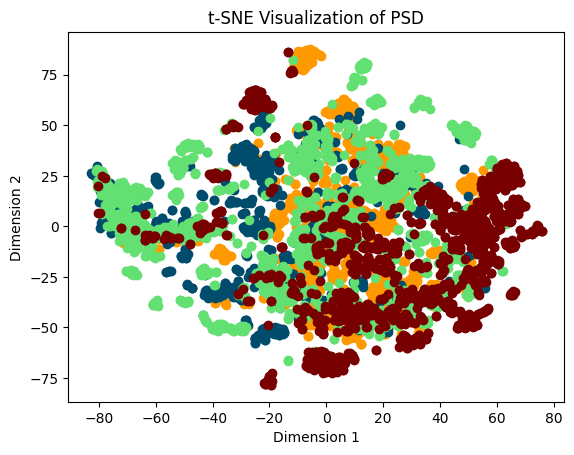

In [ ]:
#@title PSD t-SNE Visualization

tsne = TSNE(n_components=2,perplexity = 20, random_state=42)
data_2d = tsne.fit_transform(np.array(psd_train))
plt.scatter(data_2d[y_train==0, 0], data_2d[y_train==0, 1], label='Class A', color='#FF9900')
plt.scatter(data_2d[y_train==1, 0], data_2d[y_train==1, 1], label='Class B', color='#004C6D')
plt.scatter(data_2d[y_train==2, 0], data_2d[y_train==2, 1], label='Class C', color='#63E072')
plt.scatter(data_2d[y_train==3, 0], data_2d[y_train==3, 1], label='Class D', color='#790000')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization of PSD')

plt.show()

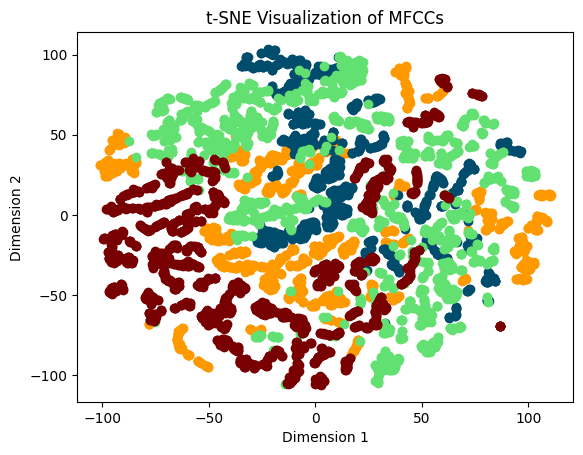

In [ ]:
#@title MFCCs t-SNE Visualization

tsne = TSNE(n_components=2,perplexity = 5, random_state=2)
data_2d = tsne.fit_transform(np.array(mfcc_train))
plt.scatter(data_2d[y_train==0, 0], data_2d[y_train==0, 1], label='Class A', color='#FF9900')
plt.scatter(data_2d[y_train==1, 0], data_2d[y_train==1, 1], label='Class B', color='#004C6D')
plt.scatter(data_2d[y_train==2, 0], data_2d[y_train==2, 1], label='Class C', color='#63E072')
plt.scatter(data_2d[y_train==3, 0], data_2d[y_train==3, 1], label='Class D', color='#790000')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization of MFCCs')

plt.show()

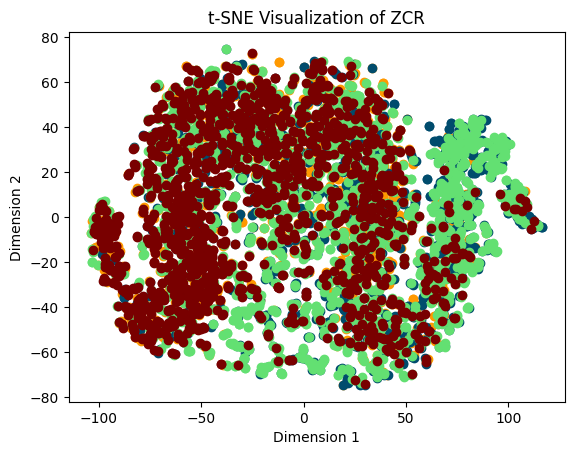

In [ ]:
#@title ZCR t-SNE Visualization

tsne = TSNE(n_components=2,perplexity = 5, random_state=2)

data_2d = tsne.fit_transform(np.array(zcr_train))
plt.scatter(data_2d[y_train==0, 0], data_2d[y_train==0, 1], label='Class A', color='#FF9900')
plt.scatter(data_2d[y_train==1, 0], data_2d[y_train==1, 1], label='Class B', color='#004C6D')
plt.scatter(data_2d[y_train==2, 0], data_2d[y_train==2, 1], label='Class C', color='#63E072')
plt.scatter(data_2d[y_train==3, 0], data_2d[y_train==3, 1], label='Class D', color='#790000')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization of ZCR')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


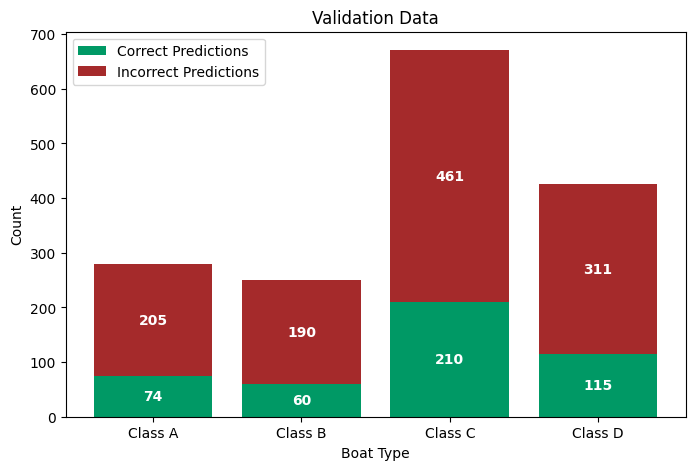

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       74       59       76       70
1       74       60       56       60
2      185      140      210      136
3      136       72      103      115

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.157783  0.265233  0.197861  0.282288
1  Class 1   0.181269  0.240000  0.206540  0.282288
2  Class 2   0.471910  0.312966  0.376344  0.282288
3  Class 3   0.301837  0.269953  0.285006  0.282288


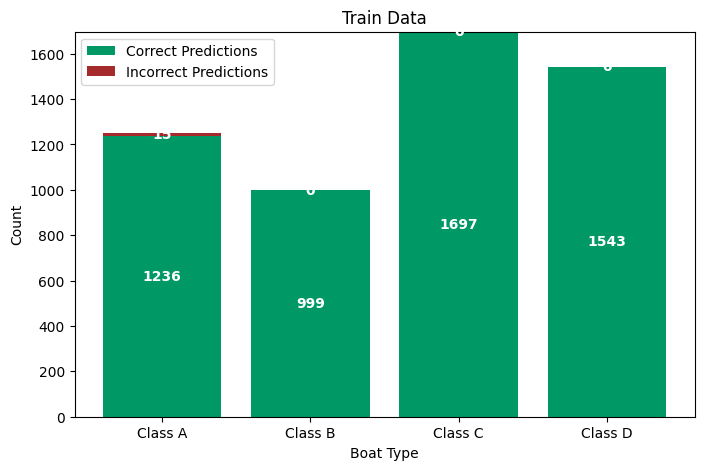

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1236        4        7        4
1        0      999        0        0
2        0        0     1697        0
3        0        0        0     1543

Metrics:
     Class  Precision   Recall  F1 Score  Accuracy
0  Class 0   1.000000  0.98801  0.993969  0.997268
1  Class 1   0.996012  1.00000  0.998002  0.997268
2  Class 2   0.995892  1.00000  0.997942  0.997268
3  Class 3   0.997414  1.00000  0.998706  0.997268


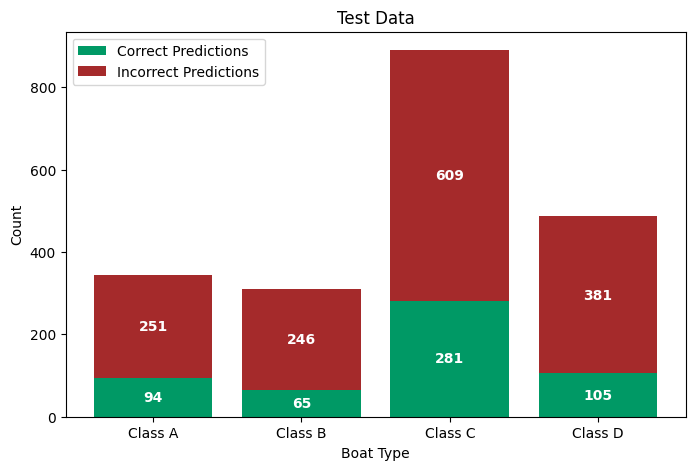

Confusion Matrix:
   Class A  Class B  Class C  Class D
0       94       59       94       98
1       90       65       97       59
2      226      155      281      228
3      144      103      134      105

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.169675  0.272464  0.209121  0.268209
1  Class 1   0.170157  0.209003  0.187590  0.268209
2  Class 2   0.463696  0.315730  0.375668  0.268209
3  Class 3   0.214286  0.216049  0.215164  0.268209


/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


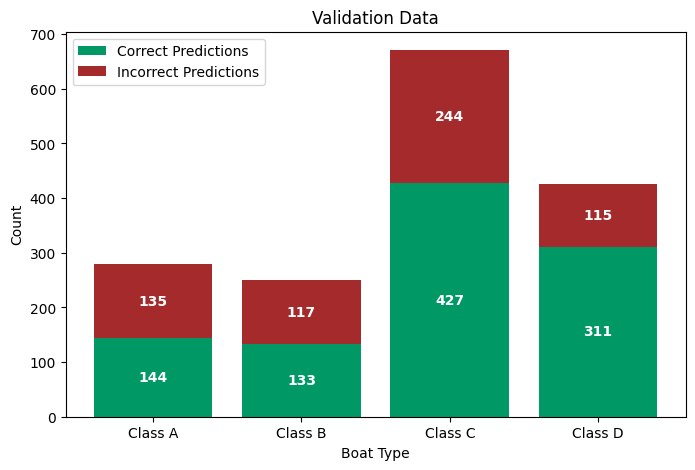

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      144       14       45       76
1       36      133       80        1
2       94      103      427       47
3       31       18       66      311

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.472131  0.516129  0.493151  0.624231
1  Class 1   0.496269  0.532000  0.513514  0.624231
2  Class 2   0.690939  0.636364  0.662529  0.624231
3  Class 3   0.714943  0.730047  0.722416  0.624231


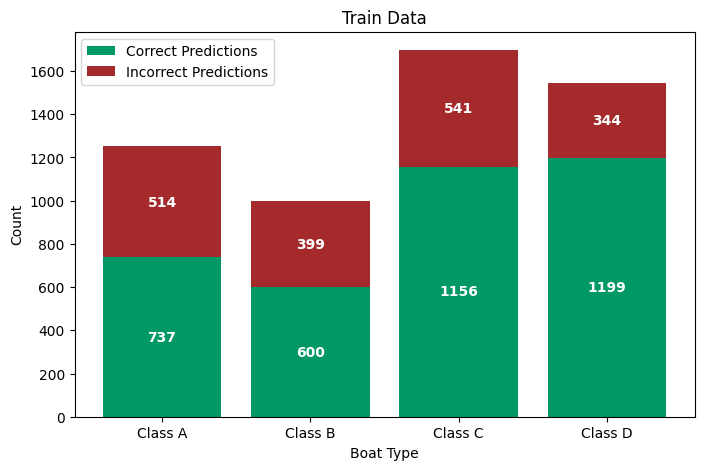

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      737       49      213      252
1      108      600      261       30
2      217      212     1156      112
3      140       40      164     1199

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.613145  0.589129  0.600897  0.672495
1  Class 1   0.665927  0.600601  0.631579  0.672495
2  Class 2   0.644370  0.681202  0.662274  0.672495
3  Class 3   0.752668  0.777058  0.764668  0.672495


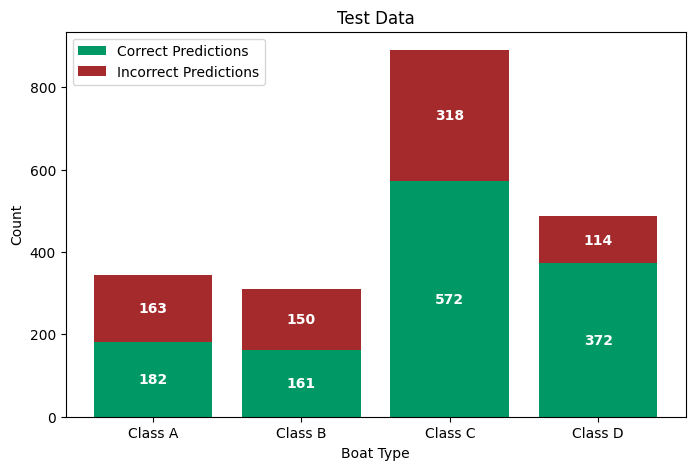

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      182       16       48       99
1       40      161      106        4
2      135      119      572       64
3       43       17       54      372

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.455000  0.527536  0.488591  0.633366
1  Class 1   0.514377  0.517685  0.516026  0.633366
2  Class 2   0.733333  0.642697  0.685030  0.633366
3  Class 3   0.690167  0.765432  0.725854  0.633366


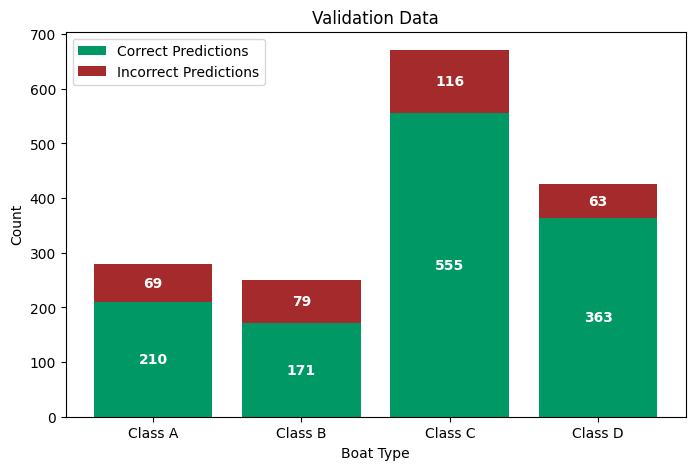

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      210       14       23       32
1       20      171       52        7
2       42       35      555       39
3       30        4       29      363

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.695364  0.752688  0.722892  0.798893
1  Class 1   0.763393  0.684000  0.721519  0.798893
2  Class 2   0.842185  0.827124  0.834586  0.798893
3  Class 3   0.823129  0.852113  0.837370  0.798893


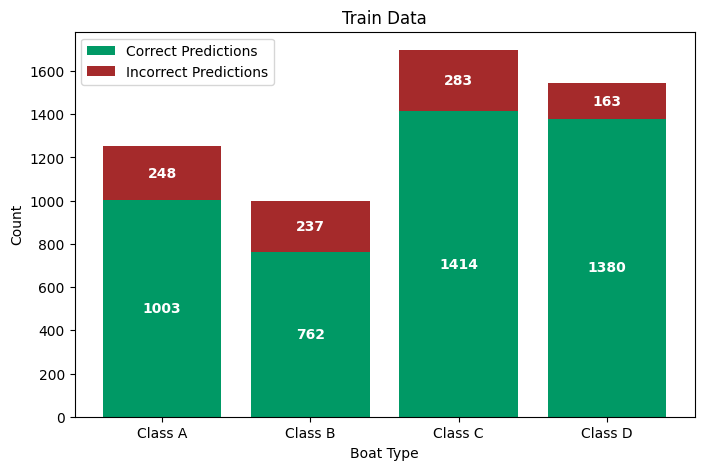

Confusion Matrix:
   Class A  Class B  Class C  Class D
0     1003       48       93      107
1       50      762      156       31
2       92       84     1414      107
3       79       14       70     1380

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.819444  0.801759  0.810505  0.830419
1  Class 1   0.839207  0.762763  0.799161  0.830419
2  Class 2   0.815926  0.833235  0.824490  0.830419
3  Class 3   0.849231  0.894362  0.871212  0.830419


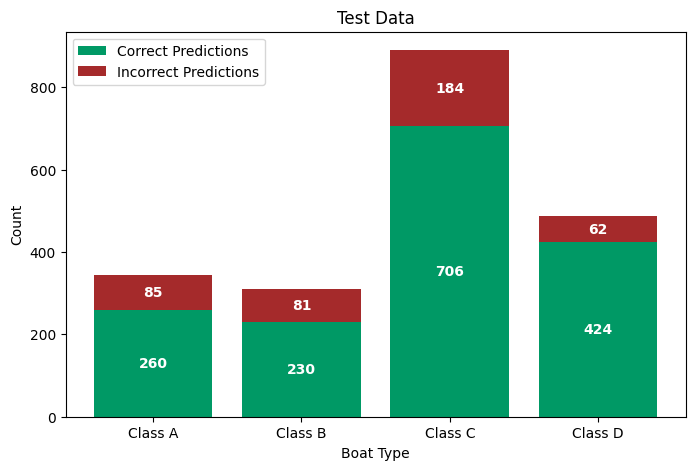

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      260       17       40       28
1       23      230       50        8
2       65       58      706       61
3       26        3       33      424

Metrics:
     Class  Precision    Recall  F1 Score  Accuracy
0  Class 0   0.695187  0.753623  0.723227  0.797244
1  Class 1   0.746753  0.739550  0.743134  0.797244
2  Class 2   0.851628  0.793258  0.821408  0.797244
3  Class 3   0.813820  0.872428  0.842105  0.797244


In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = dataload("data_exp.pkl")
metrics, matrix = get_LR_rawdata(1)
mfcc_train, mfcc_val, mfcc_test = get_mfcc()
metrics1, matrix1 = get_LR_mfcc(1)
psd_train, psd_val, psd_test = get_psd()
metrics2, matrix2 = get_LR_psd(1)